In [1]:
import edward as ed
import numpy as np
import tensorflow as tf

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
sess = tf.InteractiveSession()

In [3]:
floatX = 'float32'
np.random.seed(1234)
N = 10

X = np.random.normal(size=[N,3]).astype(floatX)
X[:,0] = (X[:,0] - X[:,1])/2
X[:,-1] = 1
ystd = 0.5

y_obs = 2*X[:,0] + X[:,1] + 3 + np.random.normal(size=N)*ystd

In [4]:
T = 40000
# c_q = ed.models.Empirical(tf.Variable(np.zeros([T, 3], dtype=floatX), name='coefs_trace'))
c0_q = ed.models.Empirical(tf.Variable(np.zeros([T, 1], dtype=floatX), name='c0_trace'))
c1_q = ed.models.Empirical(tf.Variable(np.zeros([T, 2], dtype=floatX), name='c1_trace'))

extr = lambda *x: list(map(lambda x: x.get_variables()[0], x))
c_q = ed.models.Empirical(tf.concat(extr(c0_q, c1_q), axis=-1))

In [5]:
# coefs = ed.models.Normal(loc=[0.,0.,0], scale=5.)
# c0i = tf.placeholder_with_default(False, shape=())
# c1i = tf.placeholder_with_default(False, shape=())

c0 = ed.models.Normal(loc=[0.], scale=5.)
# c0_ = tf.where(c0i, c0, c0_q)

c1 = ed.models.Normal(loc=[0.,0.], scale=5.)
# c1_ = tf.where(c1i, c1, c1_q)

coefs = tf.concat([c0,c1], axis=0)

y = ed.models.Normal(loc=tf.matmul(X, coefs[:,tf.newaxis])[:,0],scale=ystd)

In [6]:
# ic = ed.HMC({coefs: c_q}, data={y:y_obs})
ic0 = ed.HMC({c0: c0_q}, data={y:y_obs})
ic1 = ed.HMC({c1: c1_q}, data={y:y_obs})

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


In [7]:
# ic.initialize(step_size=1e-2)
ic0.initialize(step_size=1e-3)
ic1.initialize(step_size=1e-3)
tf.global_variables_initializer().run()

In [8]:
# for i in range(ic.n_iter):
#     res = ic.update()
#     ic.print_progress(res)
for i in range(ic0.n_iter):
    res = ic0.update({c1:c1_q.get_variables()[0].eval()[max(0,i-1)]})
    ic1.update({c0:c0_q.get_variables()[0].eval()[i]})
    ic0.print_progress(res)

40000/40000 [100%] ██████████████████████████████ Elapsed: 110s | Acceptance Rate: 0.507


In [9]:
samples = []
for _ in range(1000):
    s = c_q.eval()
    samples.append(s)
samples = np.array(samples)

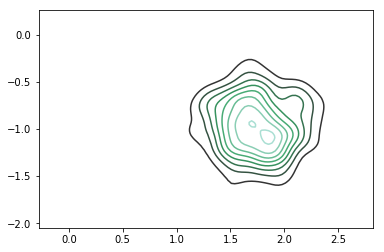

In [10]:
sns.kdeplot(samples[:,0], samples[:,1])
plt.show()

In [22]:
c_q.eval({c1_q:np.zeros([2])})

array([1.7595724, 0.       , 0.       ], dtype=float32)

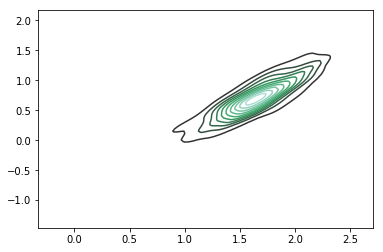

In [10]:
sns.kdeplot(samples[:,0], samples[:,1])
plt.show()